# xopt Tutorial: NSGA-II constrained

In [1]:
import array
import random
import json

import time

import numpy as np

from deap import base, tools, algorithms
from xopt import creator

import matplotlib.pyplot as plt

from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence

from deap.benchmarks.tools import diversity, convergence, hypervolume

# Custom Fitness with Constraints

In [2]:
from collections import Sequence

class FitnessWithConstraints2(base.Fitness):
    """
    Modification of base Fitness class to include constraints
    
    """
    
    def __init__(self, values=(), constraints=None):
        if self.weights is None:
            raise TypeError("Can't instantiate abstract %r with abstract "
                "attribute weights." % (self.__class__))
        
        if not isinstance(self.weights, Sequence):
            raise TypeError("Attribute weights of %r must be a sequence." 
                % self.__class__)
        
        if len(values) > 0:
            self.values = values
        if constraints:
            self.cvalues = constraints    
        else:
            self.cvalues = None
            
    def feasible(self):
        if not self.cvalues:
            return True
        """A feasible solution must have all constraints >= 0"""
        if any([x < 0 for x in self.cvalues]):
            return False
        else:
            return True

    def dominates(self, other, obj=slice(None)):
        """A feasible solution must have all constraints >= 0"""
        if not self.cvalues:
            return self.old_dominates(other, obj=obj)
        f1 = self.feasible()
        f2 = other.feasible()
        if (f1 and f2):
            return self.old_dominates(other, obj=obj)
        elif (f1 and not f2):
            return True
        elif (f2 and not f1):
            return False
        else:
            # Both infeasible
            is_better = False
            for self_cvalue, other_cvalue in zip(self.cvalues, other.cvalues):
                if (self_cvalue >= 0 and other_cvalue >= 0):
                    continue
                if (self_cvalue < other_cvalue):
                    return False
                elif (self_cvalue > other_cvalue):
                    return True
            return is_better
           
    
    def old_dominates(self, other, obj=slice(None)):
        """Return true if each objective of *self* is not strictly worse than 
        the corresponding objective of *other* and at least one objective is 
        strictly better.

        :param obj: Slice indicating on which objectives the domination is 
                    tested. The default value is `slice(None)`, representing
                    every objectives.
        """
        not_equal = False
        for self_wvalue, other_wvalue in zip(self.wvalues[obj], other.wvalues[obj]):
            if self_wvalue > other_wvalue:
                not_equal = True
            elif self_wvalue < other_wvalue:
                return False                
        return not_equal
    
    def __deepcopy__(self, memo):
        """Replace the basic deepcopy function with a faster one.
        
        It assumes that the elements in the :attr:`values` tuple are 
        immutable and the fitness does not contain any other object 
        than :attr:`values` and :attr:`weights`.
        """
        copy_ = self.__class__()
        copy_.wvalues = self.wvalues
        copy_.cvalues = self.cvalues
        return copy_    
        
    

# Test problems (pick one)

In [3]:
NAME = 'CONSTR'
BOUND_LOW, BOUND_UP = [0.1, 0] , [1, 5]
WEIGHTS = [-1, -1] # Minimize
NDIM = 2
N_CONSTRAINTS = 2

def CONSTR(individual):
    #time.sleep(.01)
    x1=individual[0]
    x2=individual[1]
    objectives =  (x1, (1.0+x2)/x1)
    constraints = (x2+9*x1-6.0, -x2+9*x1-1.0) # Should be >= 0 
    return (objectives, constraints)

F = CONSTR
# For plotting
X_RANGE = [0.1, 1]
Y_RANGE = [0, 10]

In [3]:
NAME = 'TNK'
BOUND_LOW, BOUND_UP = [0.0, 0.0], [3.14159, 3.14159]  
WEIGHTS = [-1, -1] # Minimize
NDIM = 2
N_CONSTRAINTS = 2

def TNK(individual):    
    x1=individual[0]
    x2=individual[1]
    objectives =  (x1, x2)
    constraints = (x1**2+x2**2-1.0 - 0.1*np.cos(16*np.arctan2(x1, x2)), 0.5-(x1-0.5)**2-(x2-0.5)**2 )
    return (objectives, constraints, (x1, x2))

F = TNK
X_RANGE = [0, 1.4]
Y_RANGE = [0, 1.4]

In [ ]:
NAME = 'SRN'
BOUND_LOW, BOUND_UP = [-20.0, -20.0], [20.0, 20.0]  
WEIGHTS = [-1, -1] # Minimize
NDIM = 2
N_CONSTRAINTS = 2
def SRN(individual):    
    x1=individual[0]
    x2=individual[1]
    objectives = ( (x1-2.0)**2 + (x2-1.0)**2+2.0,  9*x1-(x2-1.0)**2 )
    constraints = (225.0-x1**2-x2**2, -10.0 -x1 - 3*x2 )
    return (objectives, constraints)

F = SRN
X_RANGE = [0, 300]
Y_RANGE = [-300, 150]

# Create classes

In [4]:
creator.create('FitnessMin', FitnessWithConstraints2, weights=WEIGHTS)
creator.create('Individual', array.array, typecode='d', fitness=creator.FitnessMin)

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [5]:
creator.Individual([1,2,3])

Individual('d', [1.0, 2.0, 3.0])

# Make toolbox

In [6]:
toolbox = base.Toolbox()

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# scoop map function
#toolbox.register('map', futures.map)
toolbox.register('map', map) 


# NSGA2 specific
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)


# Test function
toolbox.register("evaluate", F)

In [7]:
# Example population
toolbox.population(4)

[Individual('d', [0.49308241448458723, 4.9984112916445]),
 Individual('d', [0.6461701415573716, 1.9626556025737045]),
 Individual('d', [0.5994514033015124, 2.6298929535959488]),
 Individual('d', [0.33204367331462514, 0.7908725378275006])]

# Parallel evaluation method (Pick one)

In [8]:
# Default map (non-parallel)
toolbox.register('map', map)

In [8]:
# Threads

from concurrent.futures import ThreadPoolExecutor

executor = ThreadPoolExecutor()
toolbox.register('map', executor.map)

In [ ]:
# Processes
from concurrent.futures import ProcessPoolExecutor

client = ProcessPoolExecutor()
toolbox.register('map', client.map)

In [ ]:
#  mpi4py
from mpi4py.futures import MPIPoolExecutor, as_completed
client = MPIPoolExecutor()


In [ ]:
# Dask distributed

from dask.distributed import Client
client = Client()
client

In [ ]:
toolbox.register('map', client.map)

In [ ]:
%%time
# Test
mypop = toolbox.population(8)
# test function
def F2(x):
    time.sleep(1)
    return F(x)

res = toolbox.map(F2, mypop)
for r in res:
    r = r.result()
    print(r)

 # DEAP example

In [9]:
def main(seed=None, evaluate_f=None):
    random.seed(seed)

    NGEN = 50
    MU = 100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    
    if evaluate_f:
        evaluate = evaluate_f
    else:
        evaluate = toolbox.evaluate
    

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    evaluate_result = toolbox.map(evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, evaluate_result):
        if 'result' in dir(fit):
            fit = fit.result()
        ind.fitness.values = fit[0]
        ind.fitness.cvalues = fit[1]


    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            if 'result' in dir(fit):
                fit = fit.result()
            ind.fitness.values = fit[0]
            ind.fitness.cvalues = fit[1]
            # Allow for additional info to be saved (for example, a dictionary of properties)
            if len(fit) > 2:
                ind.fitness.info = fit[2]

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream, hypervolume(pop, [1.0,1.0]))
        

    return pop, logbook

In [10]:
%%time
pop, stats = main(evaluate_f = F)
pop.sort(key=lambda x: x.fitness.values)

gen	evals	std                    	min                    	avg                    	max                      
0  	100  	[0.23836096 6.3545179 ]	[0.14362843 1.5323097 ]	[0.59404326 7.4947273 ]	[ 0.99196806 37.7028033 ]
1  	100  	[0.12106383 2.3303253 ]	[0.455531  1.3077373]  	[0.68521472 4.60294422]	[0.99463525 8.975927  ]   0.0
2  	100  	[0.13157218 2.44057648]	[0.455531   1.17014034]	[0.65131453 3.96808378]	[0.99463525 8.975927  ]   0.0
3  	100  	[0.13754859 2.31811241]	[0.44903037 1.09547654]	[0.64490915 3.63203296]	[0.99470616 8.9543786 ]   0.0
4  	100  	[0.14328916 2.24743937]	[0.41655053 1.04471056]	[0.63896995 3.50742404]	[0.9637603 8.8153307]     0.0
5  	100  	[0.1541319  2.20157094]	[0.41655053 1.04084559]	[0.66197402 3.19337937]	[0.98923609 8.8153307 ]   0.0
6  	100  	[0.1564561  2.32107702]	[0.41655053 1.04084559]	[0.64591566 3.36310369]	[0.98923609 8.8153307 ]   0.0
7  	100  	[0.16325184 2.49802841]	[0.41655053 1.04084559]	[0.63435972 3.63831777]	[0.98923609 8.8153307 ]   0.0


# Modularized version

In [12]:
def evaluate_population(toolbox, population):
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    evaluate_result = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, evaluate_result):
        ind.fitness.values = fit[0]
        ind.fitness.cvalues = fit[1]
        ind.fitness.n_constraints = len(fit[1])
        # Allow for additional info to be saved (for example, a dictionary of properties)
        if len(fit) > 2:
            ind.fitness.info = fit[2]

In [13]:
def evolve_population(toolbox, pop, CXPB=0.9, MU=None):
    # Vary the population
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]
    
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        
        # Crossover
        if random.random() <= CXPB:
            toolbox.mate(ind1, ind2)
        
        # Mutation
        toolbox.mutate(ind1)
        toolbox.mutate(ind2)
        del ind1.fitness.values, ind2.fitness.values
    
    
    evaluate_population(toolbox, offspring)    

    # Select the next generation population
    if not MU:
        MU = len(pop)
    
    return toolbox.select(pop + offspring, MU)
    

In [14]:
def main2(seed=None):
    random.seed(seed)

    NGEN = 50
    MU = 100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('avg', np.mean, axis=0)
    stats.register('std', np.std, axis=0)
    stats.register('min', np.min, axis=0)
    stats.register('max', np.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = 'gen', 'evals', 'std', 'min', 'avg', 'max'
    
    pop = toolbox.population(n=MU)

    evaluate_population(toolbox, pop)

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(pop), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        pop = evolve_population(toolbox, pop, CXPB=CXPB)
        
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        print(logbook.stream, hypervolume(pop, [1.0,1.0]))
        

    return pop, logbook

gen	evals	std                    	min                    	avg                    	max                    
0  	100  	[0.84622275 0.92571667]	[0.04881005 0.00881857]	[1.66310472 1.58097659]	[3.13678238 3.10499162]
1  	100  	[0.50607673 0.65042389]	[0.04881005 0.12175856]	[1.25292593 1.24558911]	[2.24627385 2.41315348] 0.027920495669468335
2  	100  	[0.37014738 0.38460356]	[0.32674917 0.05106042]	[1.05582849 0.83302809]	[1.60341082 1.5922452 ] 0.09664592489225227
3  	100  	[0.29044065 0.28872123]	[0.14638365 0.05106042]	[0.83181113 0.85267476]	[1.29901566 1.29525356] 0.15286134848865487
4  	100  	[0.24107703 0.21828412]	[0.14638365 0.34125698]	[0.74658179 0.82852891]	[1.1919937 1.1909917]   0.16072398008003377
5  	100  	[0.25793266 0.22709268]	[0.14638365 0.32973494]	[0.74881682 0.77692414]	[1.1919937 1.1909917]   0.16574724100016391
6  	100  	[0.2627526  0.23259179]	[0.14638365 0.32834261]	[0.71934704 0.75863992]	[1.1919937 1.1909917]   0.166583017218638
7  	100  	[0.25491125 0.23715307]

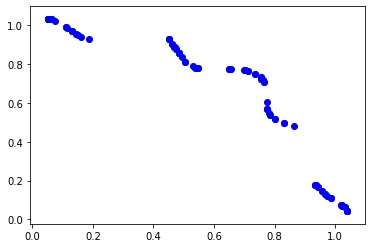

In [15]:
#if __name__ == "__main__":
#    #optimal_front = json.load(open("pareto_front/zdt4_front.json"))
#    # Use 500 of the 1000 points in the json file
#    #optimal_front = sorted(optimal_front[i] for i in range(0, len(optimal_front), 2))
    
pop, stats = main2()
pop.sort(key=lambda x: x.fitness.values)

print(stats)
#print("Convergence: ", convergence(pop, optimal_front))
#print("Diversity: ", diversity(pop, optimal_front[0], optimal_front[-1]))



 
front = np.array([ind.fitness.values for ind in pop])
#optimal_front = numpy.array(optimal_front)
#plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.show()

# Recreate plots in Deb paper

Text(0.5, 1.0, 'TNK')

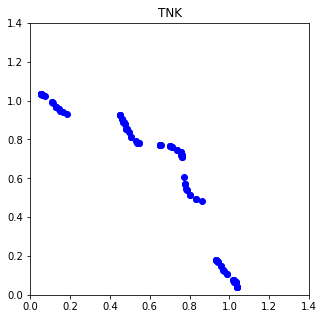

In [16]:
front = np.array([ind.fitness.values for ind in pop])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(front[:,0], front[:,1], color='blue')
ax.set_xlim(X_RANGE)
ax.set_ylim(Y_RANGE)
ax.set_aspect('auto')
ax.set_title(NAME)

# Hypervolume

In [17]:
from deap.benchmarks.tools import diversity, convergence, hypervolume

In [18]:
print("Final population hypervolume is %f" % hypervolume(pop, [10.0,10.0]))

Final population hypervolume is 98.375365


# Dask Distributed

In [ ]:
from dask.distributed import Client

from dask.distributed import as_completed

client = Client()
client

In [ ]:
#  mpi4py
from mpi4py.futures import MPIPoolExecutor, as_completed
client = MPIPoolExecutor()

In [ ]:
client=executor
from concurrent.futures import as_completed

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
client = ProcessPoolExecutor()

In [ ]:
def evaluate1(seed=None, evaluate_f=None):
    random.seed(seed)
    MU = 64*40
    CXPB = 0.9
    MUTPB = 1.0
    
    assert MU % 4 == 0, f'Population size (here {MU}) must be a multiple of 4'
    # Initial population
    pop = toolbox.population(n=MU)

    
    # Wrap evaluate to return fully evaluated individual
    def evaluate(ind):
        sleep_time = random.random() *2
        #time.sleep(sleep_time)
        fit = evaluate_f(ind)
        ind.fitness.values = fit[0]
        ind.fitness.cvalues = fit[1]
        ind.fitness.n_constraints = len(fit[1])
        
        return ind

    # Individuals that need evaluating
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    
    futures = client.map(evaluate, invalid_ind)
    iterator = as_completed(futures)
    
    # Clear pop
    pop = []
    for res in iterator:
        ind = res.result()
        pop.append(ind)
evaluate1(evaluate_f = F)    

In [ ]:
# Wrap evaluate to return fully evaluated individual
def EVALUATE(vec):
    #sleep_time = random.random() *2
    #time.sleep(sleep_time)
    fit = F(vec)
    return vec, fit

def form_ind(vec, fit):
    ind = creator.Individual(vec)
    ind.fitness.values = fit[0]
    ind.fitness.cvalues = fit[1]
    ind.fitness.n_constraints = len(fit[1])    
    return ind

# Only allow vectors to be sent to evaluate
def get_vec(ind):
    #return array.array('d', [float(x) for x in ind])
    return [float(x) for x in ind]
def get_vecs(inds):
    return [get_vec(ind) for ind in inds]


get_vec([1,2,3])

In [ ]:
%%time
def evaluate2(seed=None, evaluate_f=None):
    random.seed(seed)
    MU = 8
    CXPB = 0.9
    
    MUTPB = 1.0
    
    assert MU % 4 == 0, f'Population size (here {MU}) must be a multiple of 4'
    # Initial population
    pop = toolbox.population(n=MU)

    # Individuals that need evaluating
    vecs = [get_vec(ind) for ind in pop if not ind.fitness.valid]

    print([EVALUATE(vec) for vec in vecs]   )

    #futures = client.map(EVALUATE, vecs)
    futures = [client.submit(EVALUATE, vec) for vec in vecs]
    
    
    iterator = as_completed(futures)
    
    # Clear pop
    pop = []
    for res in iterator:
        print(res)
        vec, fit = res.result()
        ind = fit #form_ind(vec, fit)
        pop.append(ind)
    return pop
evaluate2(evaluate_f = F)    

In [ ]:
client = ProcessPoolExecutor()

In [ ]:

# Wrap evaluate to return fully evaluated individual
def EVALUATE2(ind):
    sleep_time = random.random() *2
    #time.sleep(sleep_time)
    fit = F(ind)
    ind.fitness.values = fit[0]
    ind.fitness.cvalues = fit[1]
    ind.fitness.n_constraints = len(fit[1])
    
    return ind

def main3(seed=None, evaluate_f=None):
    """
    
    Continuous NSGA-II
    Dask Distributed, custom class method
    
    """
    
    
    random.seed(seed)
    MU = 64
    CXPB = 0.9
    MUTPB = 1.0
    
    assert MU % 4 == 0, f'Population size (here {MU}) must be a multiple of 4'
    # Initial population
    pop = toolbox.population(n=MU)

    
    # Wrap evaluate to return fully evaluated individual
    def evaluate(ind):
        sleep_time = random.random() *2
        #time.sleep(sleep_time)
        fit = evaluate_f(ind)
        ind.fitness.values = fit[0]
        ind.fitness.cvalues = fit[1]
        ind.fitness.n_constraints = len(fit[1])
        
        return ind

    # Individuals that need evaluating
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    
    #futures = client.map(evaluate, invalid_ind)
    futures = [client.submit(EVALUATE2, ind) for ind in invalid_ind]
    iterator = as_completed(futures)
    
    # Clear pop
    pop = []
    for future in iterator:
        ind = future.result()
        pop.append(ind)
        
    print('here')
    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    # Make inital offspring to start the iteration
    offspring0 = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)  

    #futures = client.map(evaluate, offspring0)
    futures = [client.submit(EVALUATE2, ind) for ind in offspring0]
    iterator = as_completed(futures)
    
    generation = 0
    offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
    new_offspring = []
    for res in iterator:
        print('here2')
        ind = res.result()
        print('here3')
        new_offspring.append(ind)
        
        # Add new eval
        child = offspring.pop()
        new_ind = client.submit(EVALUATE2, child)
        iterator.add(new_ind)

        if len(offspring) == 0:
            # Generational selection
            pop = toolbox.select(pop + new_offspring, MU)
            new_offspring = []
            # New offspring
            offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
            generation += 1
            if generation == 40:
                break
            print(f'Generation {generation} completed')
            
    return pop
pop = main3(evaluate_f=F)

front = np.array([ind.fitness.values for ind in pop])
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.show()


In [ ]:

def main4(seed=None, evaluate_f=None):
    """
    
    Continuous NSGA-II
    Dask Distributed, vector method
    
    """
    random.seed(seed)
    MU = 100
    CXPB = 0.9
    MUTPB = 1.0
    
    assert MU % 4 == 0, f'Population size (here {MU}) must be a multiple of 4'
    # Initial population
    pop = toolbox.population(n=MU)

    
    # Wrap evaluate to return the input and output
    def evaluate(vec):
        #sleep_time = random.random() *2
        #time.sleep(sleep_time)
        fit = evaluate_f(vec)
        return vec, fit

    def form_ind(vec, fit):
        ind = creator.Individual(vec)
        ind.fitness.values = fit[0]
        ind.fitness.cvalues = fit[1]
        ind.fitness.n_constraints = len(fit[1])    
        return ind

    # Only allow vectors to be sent to evaluate
    def get_vec(ind):
        return array.array('d', [float(x) for x in ind])
    def get_vecs(inds):
        return [get_vec(ind) for ind in inds]
    
    # Individuals that need evaluating
    vecs = [get_vec(ind) for ind in pop if not ind.fitness.valid]
    
    futures = client.map(evaluate, vecs)
    iterator = as_completed(futures)
    
    # Clear pop
    pop = []
    for res in iterator:
        vec, fit = res.result()
        ind = form_ind(vec, fit)
        pop.append(ind)
    
    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    # Make inital offspring to start the iteration
    vecs0 = get_vecs(algorithms.varAnd(pop, toolbox, CXPB, MUTPB) )

    futures = client.map(evaluate, vecs0)
    iterator = as_completed(futures)
    
    generation = 0
    new_vecs = get_vecs(algorithms.varAnd(pop, toolbox, CXPB, MUTPB))
    new_offspring = []
    for res in iterator:
        
        # Get a result and form the individual
        vec, fit = res.result()
        ind = form_ind(vec, fit)
        new_offspring.append(ind)
        
        # Add new job for worker
        vec = new_vecs.pop()
        future = client.submit(evaluate, vec)
        iterator.add(future)
        
        # If there are no more vecs left, advance the generation
        if len(new_vecs) == 0:
            # Generational selection
            pop = toolbox.select(pop + new_offspring, MU)
            new_offspring = []
            # New offspring
            new_vecs = get_vecs(algorithms.varAnd(pop, toolbox, CXPB, MUTPB))
            generation += 1
            if generation == 50:
                break
            print(f'Generation {generation} completed')
            
    return pop
pop = main4(evaluate_f=F)

front = np.array([ind.fitness.values for ind in pop])
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.show()

